In [14]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [15]:
import torch

In [16]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [17]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fashionmnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T045703Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1a4eb1627fb5eedeb89a9a71fa459808376644947817fbdf559d172f19d4abafb1c7023e273a60e0bd04c299f71a8ecdf56416cc125110008e3e6fc7b45e06f22a3c2525b03b6c7d449cf64784cc3da5015606ca4faf28ff5a28420db4e8c9e724df08c51e161248fcff63140b98a413aea981ae422a69ae15587eeed2419ac5fdf02ed8ef8965723059e2df8a01a83309a302e6c9a5de3cca8cba93efbea82789280d1604f2ebda808edefd6008e6a4773d6e0db8f80d63ebcf0ef4b06584356bf873a0bcbb01ea83e9a8f2e7027f80e44484dabdfe8636a770f4205deeeb7b96241b4435851d12615830573e09408ba5ff4afbfbcae86bed62c9d54dc54d08'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 72114846 bytes downloaded
Downloaded and uncompressed: fashionmnist
Data source import complete.


In [18]:
# Load Fashion MNIST data
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
num_classes = 10
epochs = 20

fashionmnist



In [19]:
# Create dataframes for train and test datasets
train_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv', sep = ',')

In [20]:
# Convert dataframes into numpy arrays of float32 type
train_data = np.array(train_df, dtype = 'float32')
test_data = np.array(test_df, dtype='float32')

In [21]:
# Slice train arrays into x and y arrays with image and label data
x_train = train_data[:,1:]/255
y_train = train_data[:,0]
x_test= test_data[:,1:]/255
y_test=test_data[:,0]
y_train.shape
len(y_train)

60000

In [22]:
# Split training data into validation and actual training data
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)


In [23]:
# Split out Training T-shirt and sneaker images into their lists
t_shirts = []
sneakers = []

for i in range (len(x_train)):
  if y_train[i] == 0:
    t_shirts.append(x_train[i])
  if y_train[i] == 7:
    sneakers.append(x_train[i])

In [24]:
# Split out Validation T-shirt and sneaker images into their lists
t_shirts_validate = []
sneakers_validate = []

for i in range (len(x_validate)):
  if y_validate[i] == 0:
    t_shirts_validate.append(x_validate[i])
  if y_validate[i] == 7:
    sneakers_validate.append(x_validate[i])

4825

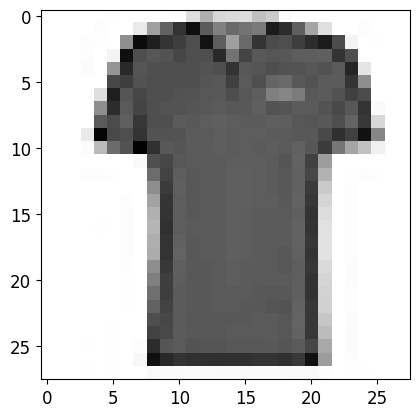

In [25]:
# Show one training T-shirt image to check
plt.imshow(t_shirts[0].reshape(28,28))
len(t_shirts)


1175

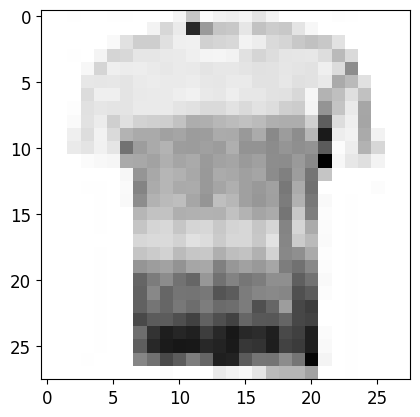

In [26]:
# Show one validation T-shirt image to check
plt.imshow(t_shirts_validate[0].reshape(28,28))
len(t_shirts_validate)

4787

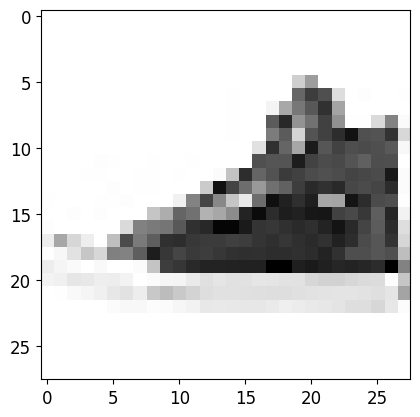

In [27]:
# Show one training sneaker image to check
plt.imshow(sneakers[0].reshape(28,28))
len(sneakers)


1213

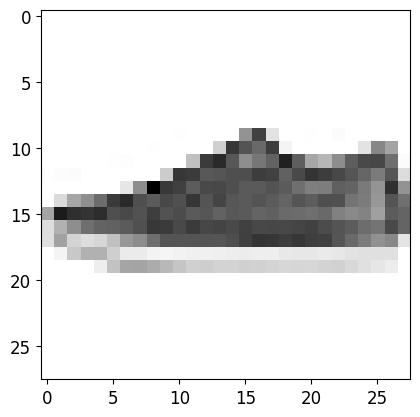

In [28]:
# Show one validation sneaker image to check
plt.imshow(sneakers_validate[0].reshape(28,28))
len(sneakers_validate)

In [31]:
# Creating a list of tensors with tshirt training data

tshirt_tensor_list = []
for t_shirt in t_shirts:
  tshirt_tensor_list.append(tensor(t_shirt))
tshirt_tensor_tuple = tuple(tshirt_tensor_list)

# Creating a list of tensors with sneakers training data

sneaker_tensor_list = []
for sneaker in sneakers:
  sneaker_tensor_list.append(tensor(sneaker))
sneaker_tensor_tuple = tuple(sneaker_tensor_list)

# Checking the length of the tshirt tensor list and sneaker tensor list

len(tshirt_tensor_list),len(sneaker_tensor_list)

(4825, 4787)

In [32]:
# Similar to the training set, creating a list of tensors with tshirt validation data

tshirt_validate_tensor_list = []
for t_shirt in t_shirts_validate:
  tshirt_validate_tensor_list.append(tensor(t_shirt))
tshirt_validate_tensor_tuple = tuple(tshirt_validate_tensor_list)

# Creating a list of tensors with sneaker validation data

sneaker_validate_tensor_list = []
for sneaker in sneakers_validate:
  sneaker_validate_tensor_list.append(tensor(sneaker))
sneaker_validate_tensor_tuple = tuple(sneaker_validate_tensor_list)

# Checking the length of the tshirt tensor list and sneaker tensor list
# The validation set is 20% of the full dataset

len(tshirt_validate_tensor_list),len(sneaker_validate_tensor_list)

(1175, 1213)

In [33]:
# Stack the t-shirt tensors into a single tensor and convert to float
# Stack the sneaker tensors into a single tensor and convert to float
# Normalize pixel values to be between 0 and 1
# Print the shape of the stacked t-shirts tensor

stacked_tshirts = torch.stack(tshirt_tensor_tuple).float()/255
stacked_sneakers = torch.stack(sneaker_tensor_tuple).float()/255
stacked_tshirts.shape

torch.Size([4825, 784])

In [34]:
# Stack the t-shirt validation tensors into a single tensor and convert to float
# Stack the sneaker validation tensors into a single tensor and convert to float
# Normalize pixel values to be between 0 and 1
# Print the shape of the stacked t-shirts validation tensor

stacked_tshirts_validate = torch.stack(tshirt_validate_tensor_tuple).float()/255
stacked_sneakers_validate = torch.stack(sneaker_validate_tensor_tuple).float()/255
stacked_tshirts_validate.shape

torch.Size([1175, 784])

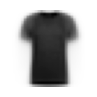

In [35]:
# Calculate the mean t-shirt image by averaging all t-shirt images in the stack
# Reshape the mean t-shirt tensor to a 28x28 image and display it

mean_tshirt = stacked_tshirts.mean(0)
show_image(mean_tshirt.reshape(28,28));

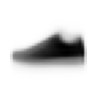

In [36]:
# Calculate the mean sneaker image by averaging all sneaker images in the stack
# Reshape the mean sneaker tensor to a 28x28 image and display it

mean_sneaker = stacked_sneakers.mean(0)
show_image(mean_sneaker.reshape(28,28));

In [37]:
#  Define a function to calculate the distance between two images

def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [38]:
# Define a function that determines whether an image is a tshirt

def is_tshirt(x): return mnist_distance(x,mean_tshirt) < mnist_distance(x,mean_sneaker)

In [41]:
# We concatenate the tshirt and the sneakers tensors

train_x = torch.cat([stacked_tshirts, stacked_sneakers]).view(-1, 28*28)

In [42]:
# Check the lengths of the tshirt and sneakers lists

len(t_shirts), len(sneakers), len(t_shirt)

(4825, 4787, 784)

In [43]:
# Create data set for training images


train_y = tensor([1]*len(t_shirts) + [0]*len(sneakers)).unsqueeze(1)
train_x.shape,train_y.shape
dset = list(zip(train_x,train_y))
train_x.shape, train_y.shape

(torch.Size([9612, 784]), torch.Size([9612, 1]))

In [44]:
# Create data set for validation images

valid_x = torch.cat([stacked_tshirts_validate, stacked_sneakers_validate]).view(-1, 28*28)
valid_y = tensor([1]*len(stacked_tshirts_validate) + [0]*len(stacked_sneakers_validate)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
valid_x.shape, valid_y.shape

(torch.Size([2388, 784]), torch.Size([2388, 1]))

In [45]:
# Initialize weights and bias with random values
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

In [46]:
# Calculate prediction for one image
#(train_x[0]*weights.T).sum() + bias

tensor([0.3575], grad_fn=<AddBackward0>)

In [47]:
# Define a function to perform a linear transformation
# Generate predictions using the linear1 function on the training data
# Display the predictions


def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[0.3575],
        [0.3281],
        [0.2681],
        ...,
        [0.3379],
        [0.3626],
        [0.3622]], grad_fn=<AddBackward0>)

In [48]:
# Compare predictions to actual labels to determine correctness
# Compares the converted predictions to the true labels

corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [49]:
# Calculate the accuracy of the predictions

corrects.float().mean().item()

0.5019766688346863

In [50]:
# Define a custom loss function for MNIST classification

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [51]:
# Initialize weight and bias parameters

weights = init_params((28*28,1))
bias = init_params(1)

In [52]:
# Create Data Loader for training data

dl = DataLoader(dset, batch_size=256, shuffle=True)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [53]:
# Create Data Loader for validation data

valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)

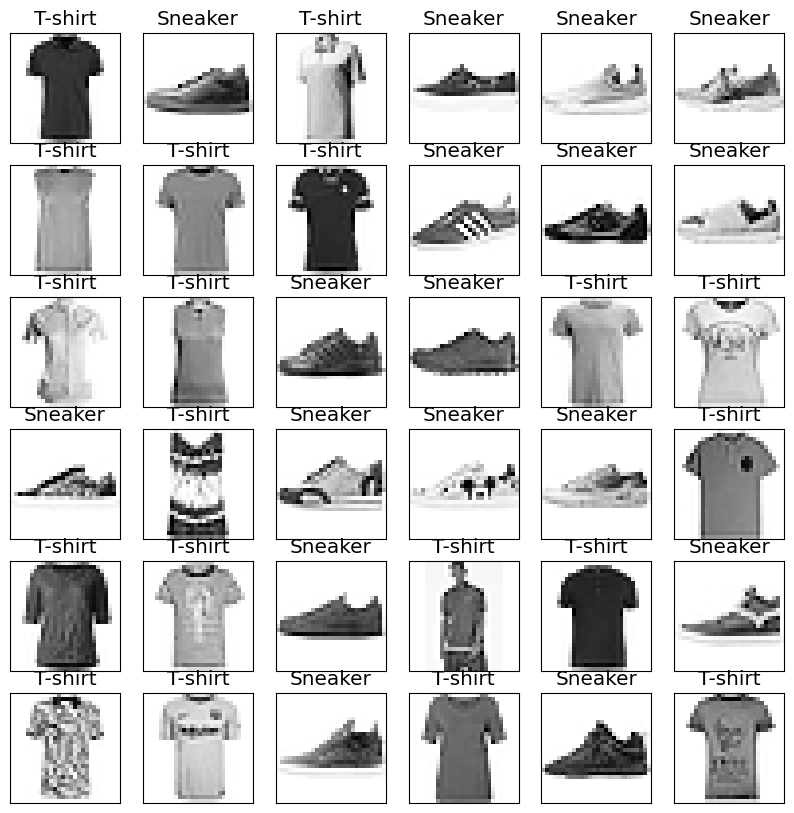

In [54]:
# Create a mini batch for testing

batch = train_x[:4]
#batch.shape

#show_image(train_x[10].reshape(28,28));
class_names = ['Sneaker', 'T-shirt']
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(xb[i].reshape((28,28)))
    label_index = int(yb[i])
    plt.title(class_names[label_index])
plt.show()

In [82]:
# Generate predictions for a batch of data using the linear1 function

preds = linear1(batch)
preds

tensor([[0.3105],
        [0.3085],
        [0.2086],
        [0.2690]], grad_fn=<AddBackward0>)

In [56]:
# Calculate the loss for the first 4 predictions using the mnist_loss function

loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.5730, grad_fn=<MeanBackward0>)

In [57]:
# Calculate the gradients of the loss with respect to the model parameters

loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0004), tensor([-0.2446]))

In [58]:
# Define a function to calculate the gradients for a batch of data

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [59]:
# Test the calc_grad function

#calc_grad(batch, train_y[:4], linear1)
#weights.grad.mean(),bias.grad

(tensor(-0.0008), tensor([-0.4893]))

In [60]:
# Calculate gradients for the batch using the calc_grad function and linear1 model

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0012), tensor([-0.7339]))

In [61]:
# Reset the gradients of the weights and bias to zero

weights.grad.zero_()
bias.grad.zero_();

In [62]:
# Define a function to train the model for one epoch

def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [63]:
# Compare predictions to the first 4 true labels

(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [64]:
# Define a function to calculate accuracy for a batch of data

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [65]:
# Calculate the accuracy of predictions for the batch using the batch_accuracy function

batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [66]:
# Define a function to calculate the validation accuracy for an epoch

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [67]:
# Calculate and print the validation accuracy for the linear1 model

validate_epoch(linear1)

0.509

In [68]:
# Set the learning rate
# Train the model for one epoch using the specified learning rate and parameters
# And calculate and print the validation accuracy after training


lr = 2.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5082

In [69]:
# Train the model for 20 epochs and print validation accuracy after each epoch

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.505 0.5006 0.7359 0.5892 0.4918 0.4942 0.495 0.491 0.4926 0.495 0.4922 0.4926 0.5986 0.7098 0.9789 0.6534 0.5797 0.9887 0.941 0.98 

In [70]:
# Optimizer
# Create a linear model using PyTorch's nn.Linear module
# Get the weights and bias of the linear model

linear_model = nn.Linear(28*28,1)

w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [71]:
# Define a basic optimizer class
# Initialize the optimizer with model parameters and learning rate
# Perform a single optimization step (update parameters)
# Reset gradients to zero

class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [72]:
# Create an instance of the BasicOptim optimizer for the linear model

opt = BasicOptim(linear_model.parameters(), lr)

In [73]:
# Define a function to train the model for one epoch
# Iterate over batches in the dataloader
# Calculate gradients for the batch
# Update model parameters using the optimizer

def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [74]:
#validate_epoch(linear_model)

0.4926

In [75]:
# Define a function to train the model for a specified number of epochs
# Iterate for the given number of epochs
# Train the model for one epoch
# Calculate and print validation accuracy


def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [76]:
# Train the linear_model for 20 epochs

train_model(linear_model, 20)

0.4846 0.4902 0.4974 0.4926 0.495 0.4966 0.4838 0.4886 0.495 0.4846 0.4982 0.4886 0.4934 0.9331 0.9089 0.993 0.9933 0.9648 0.9902 0.9812 

In [77]:
# Create a linear model using PyTorch
# Create an SGD optimizer for the linear model
# Train the linear model for 20 epochs

linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4902 0.4878 0.4918 0.4926 0.491 0.4878 0.4862 0.4846 0.4894 0.4902 0.4902 0.894 0.9503 0.9906 0.9957 0.9957 0.9875 0.9096 0.9695 0.9961 

In [78]:
# Create a DataLoaders object from the training and validation dataloaders

dls = DataLoaders(dl, valid_dl)

In [79]:
# Create a Learner object for training


learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [81]:
# Train the model for 15 epochs with a learning rate of 2

learn.fit(15, lr=2)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.484830,0.485046,0.492044,00:00
1,0.483598,0.482920,0.492044,00:00
2,0.482061,0.481104,0.492044,00:00
3,0.480445,0.479154,0.492044,00:00
4,0.478667,0.477244,0.525963,00:00
5,0.476829,0.475345,0.754606,00:00
6,0.474945,0.473183,0.995394,00:00
7,0.473154,0.471265,0.993719,00:00
8,0.471235,0.469559,0.994556,00:00
9,0.469283,0.467688,0.995812,00:00
